# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#connect to database
pg_connection = {'host': 'dsstudents.skillbox.ru',
                 'port': 5432,
                 'dbname': 'human_resources',
                 'user': 'readonly',
                 'password': '6hajV34RTQfmxhS'}
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

In [3]:
# tables in db
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
cursor.execute(sql_str)
tables_data = [i for i in cursor.fetchall()]
conn.commit()

print(f'Tables in database: {tables_data}')

Tables in database: [('hr_dataset',), ('production_staff',), ('recruiting_costs',), ('salary_grid',)]


In [4]:
df_hr = pd.read_sql_query('SELECT * FROM public.hr_dataset LIMIT 5;', conn)
df_hr

C:\Users\olcha\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


## Hypotesis 1 ##

Check correlation between Performance Score and Manager Name

In [5]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str_hyp_1 = 'SELECT "Manager Name", "Performance Score", COUNT(*) FROM public.hr_dataset GROUP BY "Manager Name",  "Performance Score";'

cursor.execute(sql_str_hyp_1)

newlist = cursor.fetchall()

conn.commit()
conn.close()

In [6]:
perfomance_dict = {}

# add manager names as keys to dict
[perfomance_dict.update({x[0]:{}}) for x in newlist]
perfomance_dict

{'Amy Dunn': {},
 'Lynn Daneault': {},
 'Webster Butler': {},
 'David Stanley': {},
 'Simon Roup': {},
 'Brannon Miller': {},
 'Brandon R. LeBlanc': {},
 'Kissy Sullivan': {},
 'Ketsia Liebig': {},
 'Eric Dougall': {},
 'Elijiah Gray': {},
 'Kelley Spirea': {},
 'Janet King': {},
 'Michael Albert': {},
 'Peter Monroe': {},
 'Alex Sweetwater': {},
 'Jennifer Zamora': {},
 'John Smith': {},
 'Board of Directors': {},
 'Debra Houlihan': {},
 'Brian Champaigne': {}}

In [7]:
# add perf score as value to dict
for row in newlist:
    name = row[0]
    perf_score = row[1]
    count = row[2]
    perfomance_dict[name].update({perf_score:count})

perfomance_dict

{'Amy Dunn': {'Exceptional': 1,
  'N/A- too early to review': 5,
  'PIP': 1,
  'Fully Meets': 11,
  '90-day meets': 1,
  'Exceeds': 2},
 'Lynn Daneault': {'N/A- too early to review': 1,
  'Fully Meets': 8,
  'PIP': 1,
  'Exceeds': 2,
  '90-day meets': 1},
 'Webster Butler': {'Needs Improvement': 2,
  'Fully Meets': 11,
  'Exceeds': 2,
  'N/A- too early to review': 3,
  '90-day meets': 3},
 'David Stanley': {'Fully Meets': 15,
  'N/A- too early to review': 4,
  '90-day meets': 1,
  'Exceeds': 1},
 'Simon Roup': {'N/A- too early to review': 4,
  'Exceptional': 2,
  'Fully Meets': 6,
  '90-day meets': 5},
 'Brannon Miller': {'Needs Improvement': 1,
  'Fully Meets': 8,
  'Exceptional': 2,
  'PIP': 4,
  'Exceeds': 5,
  '90-day meets': 1},
 'Brandon R. LeBlanc': {'Fully Meets': 4,
  '90-day meets': 1,
  'N/A- too early to review': 2},
 'Kissy Sullivan': {'90-day meets': 3,
  'N/A- too early to review': 1,
  'Exceptional': 1,
  'Needs Improvement': 1,
  'PIP': 1,
  'Exceeds': 1,
  'Fully Meet

In [8]:
# dict to df
df_perfomance_score = pd.DataFrame(perfomance_dict).T

df_perfomance_score

,Exceptional,N/A- too early to review,PIP,Fully Meets,90-day meets,Exceeds,Needs Improvement
Amy Dunn,1.0,5.0,1.0,11.0,1.0,2.0,NaN
Lynn Daneault,NaN,1.0,1.0,8.0,1.0,2.0,NaN
Webster Butler,NaN,3.0,NaN,11.0,3.0,2.0,2.0
David Stanley,NaN,4.0,NaN,15.0,1.0,1.0,NaN
Simon Roup,2.0,4.0,NaN,6.0,5.0,NaN,NaN
Brannon Miller,2.0,NaN,4.0,8.0,1.0,5.0,1.0
Brandon R. LeBlanc,NaN,2.0,NaN,4.0,1.0,NaN,NaN
Kissy Sullivan,1.0,1.0,1.0,14.0,3.0,1.0,1.0
Ketsia Liebig,NaN,2.0,NaN,14.0,2.0,2.0,1.0
Eric Dougall,NaN,NaN,NaN,3.0,NaN,1.0,NaN


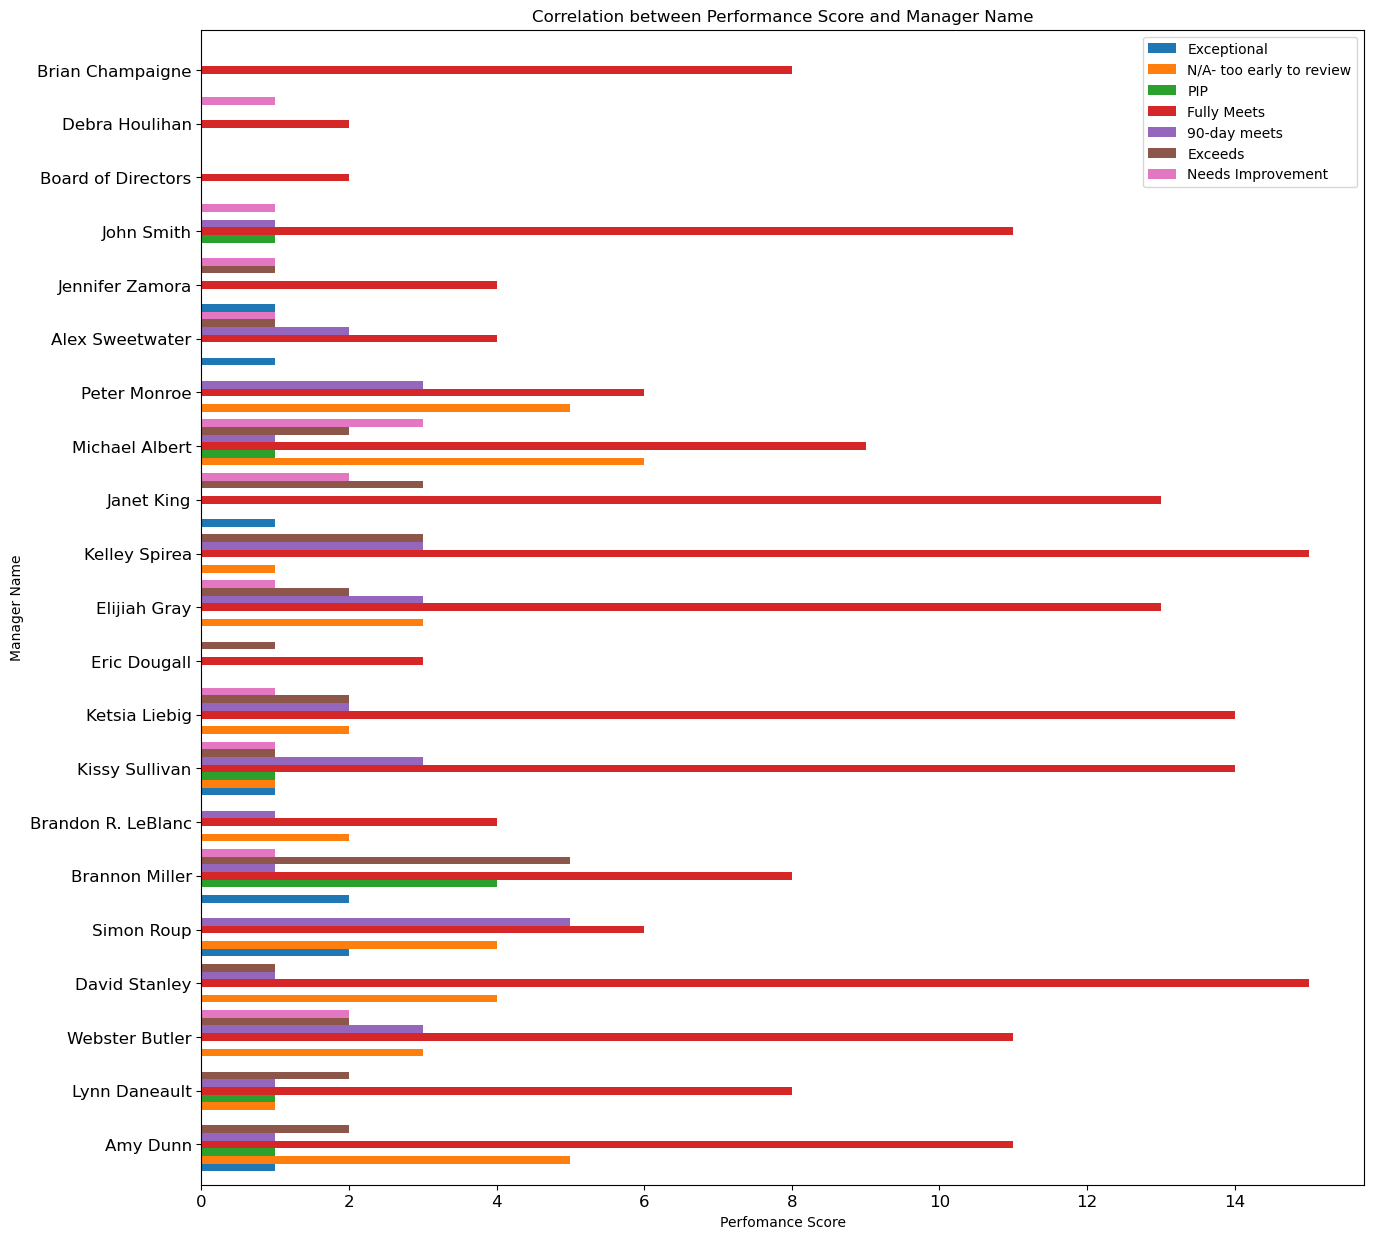

In [9]:
# make barh chart
ax = df_perfomance_score.plot.barh(fontsize=12, figsize=(15, 15), width=1, title='Correlation between Performance Score and Manager Name')
ax.set_xlabel('Perfomance Score')
ax.set_ylabel('Manager Name')

plt.show()

### Выводы ###

Исходя из графика можно сделать следующие выводы:

1.  У большинства менеджеров сотрудники соответствуют требованиям, за исключением Michael Albert.

2.  График подтверждает гипотезу, что существует корреляция между performance score и менеджером, под чьим руководством находятся сотрудники.

## Hypotesis 2 ##

Correlatioon between days in Company and marital status

In [10]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str_hyp_2 = 'SELECT "maritalstatusid", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") FROM public.hr_dataset GROUP BY "maritalstatusid";'

cursor.execute(sql_str_hyp_2)

newlist = cursor.fetchall()

conn.commit()
conn.close()

In [11]:
df_marital_status = pd.DataFrame(newlist, columns=['maritalstatusid' , 'Days']).set_index('maritalstatusid')
df_marital_status

,Days
maritalstatusid,
0,1318
1,1154
2,1056
3,1476
4,972


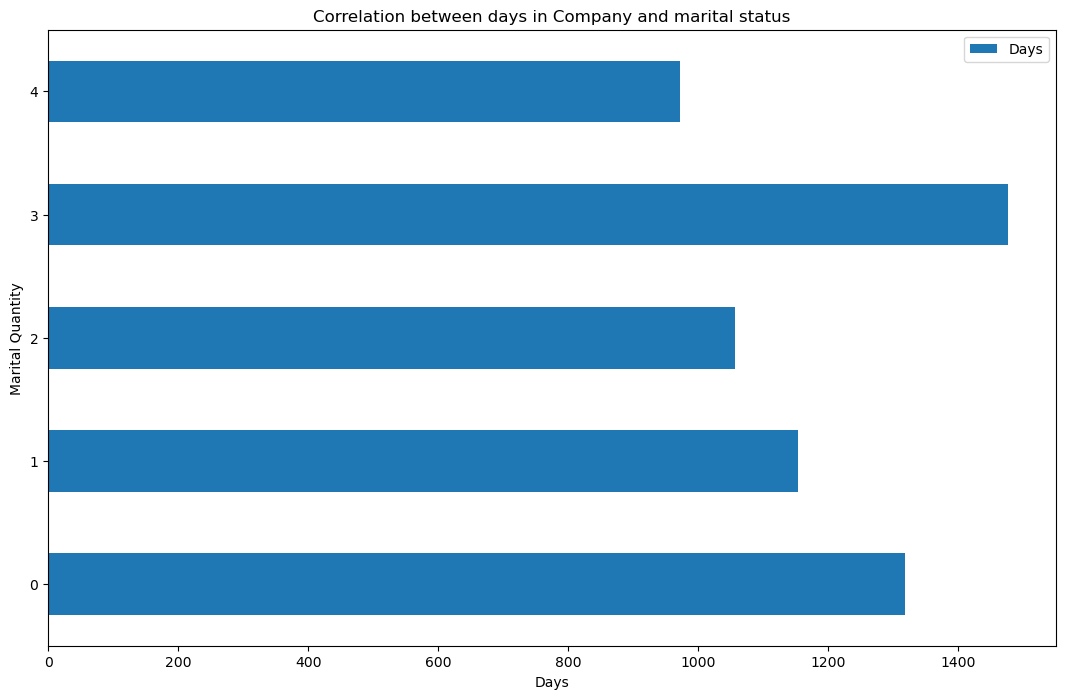

In [12]:
ax = df_marital_status.plot.barh(figsize=(13, 8), title='Correlation between days in Company and marital status')
ax.set_xlabel('Days')
ax.set_ylabel('Marital Quantity')

plt.show()

### Вывод к графику №1 ###

Исходя из графика можно сделать вывод, что в Компании больше всего дней проработали те, кто был в браке 3 раза.

In [13]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str_hyp_3 = 'SELECT "marriedid", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") FROM public.hr_dataset GROUP BY "marriedid";'

cursor.execute(sql_str_hyp_3)

newlist = cursor.fetchall()

conn.commit()
conn.close()

In [14]:
df_marital_status = pd.DataFrame(newlist, columns=['marriedid' , 'Days']).set_index('marriedid')
df_marital_status

,Days
marriedid,
0,1294
1,1154


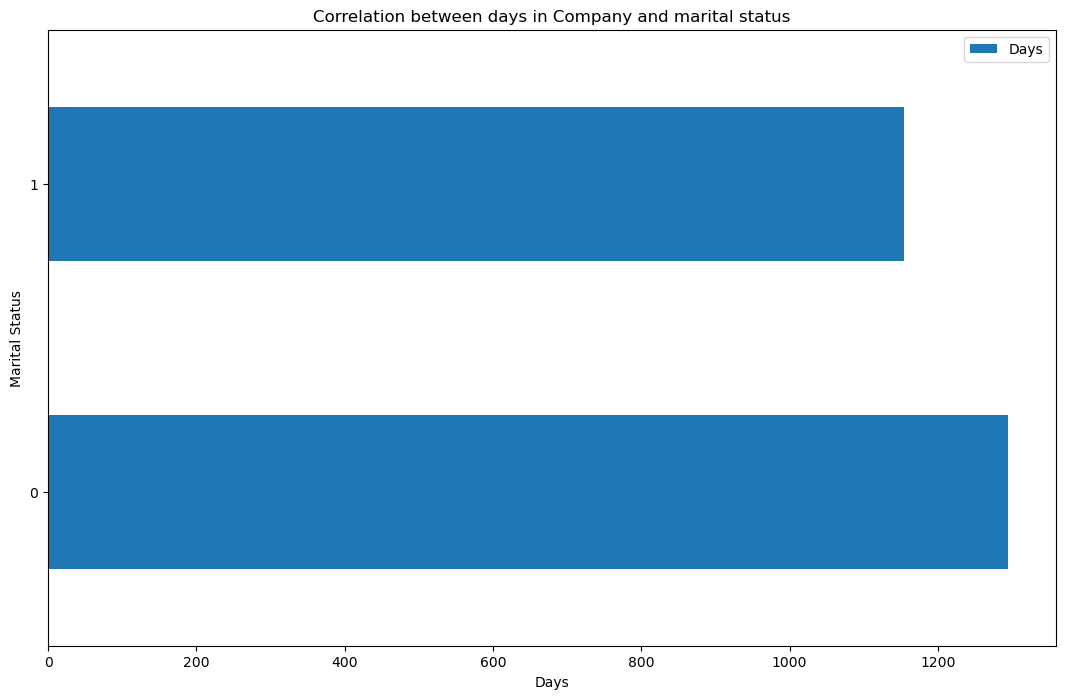

In [15]:
ax = df_marital_status.plot.barh(figsize=(13, 8), title='Correlation between days in Company and marital status')
ax.set_xlabel('Days')
ax.set_ylabel('Marital Status')

plt.show()

### Вывод к графику №2 ###

Исходя из графика можно сделать вывод, что в Компании на 140 дней больше проработали те, кто ни разу не состоял в браке.

## Вывод ##

Исходя из графиков можно сделать вывод, что существует определённая зависимость между семейным положением и количеством дней, который сотрудник провёл в Компании

## Hypotesis 3 ##

Correlation between age of employees and days in Company

In [16]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str_hyp_4 = 'SELECT "age", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") FROM public.hr_dataset GROUP BY "age";'

cursor.execute(sql_str_hyp_4)

newlist = cursor.fetchall()

conn.commit()
conn.close()

In [17]:
df_age_and_days = pd.DataFrame(newlist, columns=['age' , 'Days']).set_index('age')
df_age_and_days

,Days
age,
25,1476
26,794
27,1560
28,972
29,1476
30,940
31,1154
32,1116
33,1154


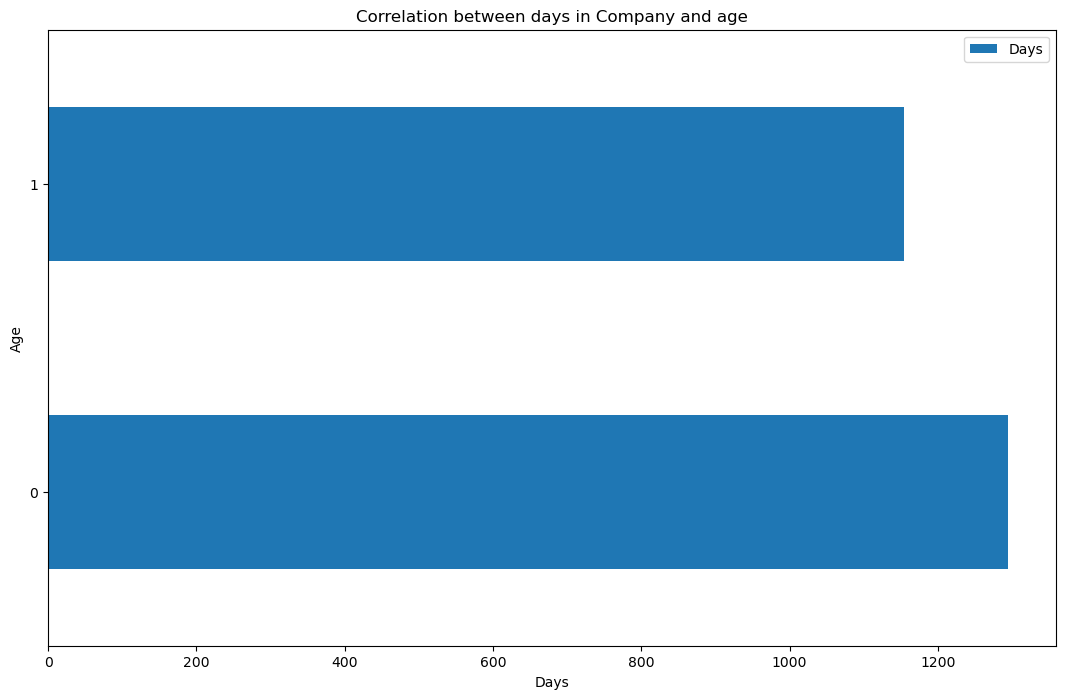

In [18]:
ax = df_marital_status.plot.barh(figsize=(13, 8), title='Correlation between days in Company and age')
ax.set_xlabel('Days')
ax.set_ylabel('Age')

plt.show()

### Вывод к графику №1 ###

Исходя из графика можно сделать вывод, что больше всего в Компании проработал сотрудник возрастом 49 лет, далее сотрудник возрастом 51 год и 59 лет.

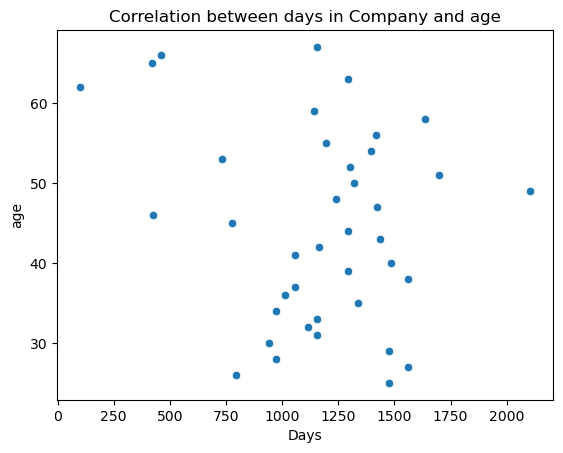

In [19]:
# check corr between age and days in Company
sns.scatterplot(x="Days", y='age', data=df_age_and_days)
plt.title('Correlation between days in Company and age')
plt.show()

## Вывод ##

Исходя из диаграммы рассеяния можно сделать вывод, что нет явной корреляции между возрастом сотрудника и количеством дней, которые он провёл в Компании. Следовательно, при подборе сотрудников можно не ориентироваться на его возраст.

## Hypotesis 4 ##

Correlation between gender of employees and days in Company

In [20]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str_hyp_5 = 'SELECT "genderid", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") FROM public.hr_dataset GROUP BY "genderid";'

cursor.execute(sql_str_hyp_5)

newlist = cursor.fetchall()

conn.commit()
conn.close()

In [21]:
df_gender_and_days = pd.DataFrame(newlist, columns=['genderid' , 'Days']).set_index('genderid')
df_gender_and_days

,Days
genderid,
0,1238
1,1238


## Вывод ##

Исходя из таблицы можно сделать вывод, что нет корреляции между полом сотрудника и количеством дней, которые он провёл в Компании.

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [38]:
import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

vk_token = ''

Take last 100 posts in Skillbox group in VK

In [47]:
from datetime import datetime, timedelta

dict_vk = {}

for i in range(100):
    dict_vk[i] = {}
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + f'&owner_id=-66669811&offset={i}&count=100&v=5.92'
    response = getjson(url)
    
    text = response['response']['items'][0]['text']
    likes = response['response']['items'][0]['likes']['count']
    reposts = response['response']['items'][0]['reposts']['count']
    date = response['response']['items'][0]['date']
    dt = (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
    
    dict_vk[i].update({'text': text,
                    'likes': likes,
                    'reposts': reposts,
                    'time': dt})
    
    print()
    print(f'text: {text}')
    print()
    print(f'likes: {likes}')
    print(f'repost: {reposts}')
    print(f'time: {dt}')
    print('--' * 50)


text: Настало ваше время в IT.

Сергей Светлаков приглашает вас на бесплатный вебинар, где вы познакомитесь с самыми востребованными профессиями в 2023 году.

Сергей ничего не понимает в IT, но эксперты Skillbox готовы ответить на все его вопросы. А вопросы будут каверзными и меткими — не сомневайтесь!

Подарки тоже будут, регистрируйтесь: https://vk.cc/cmJxfv

likes: 52
repost: 38
time: 2023-03-30 16:29:05
----------------------------------------------------------------------------------------------------

text: Мы ждем майские так, будто это бесконечный уик-энд.

А на деле — пара дней, и снова работа. Как успеть восстановить силы, а главное, перезагрузить голову за такой срок?

Несколько способов собрали в карточках — читайте!

likes: 52
repost: 29
time: 2023-05-05 17:52:12
----------------------------------------------------------------------------------------------------

text: «Я пережил настоящую мясорубку!»

Георгий Джачвадзе любит учиться — он уже прошел 14 наших курсов. Но од


text: Смотреть бэкстейджи бывает не менее интересно, чем сами сериалы.

Все потому, что готовая картина — лишь вершина громадного айсберга. А за каждым именем в титрах стоит своя увлекательная история.

В карточках собрали для вас фото со съемок «Мандалорца». Листайте и помните, что кино — это сложно, но весело и интересно.

И записывайтесь на курс «Профессия художник компьютерной графики», чтобы увидеть изнанку кинопроизводства: https://vk.cc/cnDZhj

likes: 26
repost: 8
time: 2023-04-27 12:29:00
----------------------------------------------------------------------------------------------------

text: Продолжаем делиться работами наших пользователей!

И на очереди не просто работа, а итоговый проект от участника курса «UX-дизайнер с нуля до PRO» Дмитрия Багаева.

Дмитрий показал, как будет выглядеть цифровая поверхность Маруси в смарт-ТВ. Смотрите в карточках!

А записаться на сам курс можно здесь:

likes: 12
repost: 3
time: 2023-04-26 16:00:04
---------------------------------------


text: «Выученные в игровой форме приемы можно применять в реальной жизни».

Георгий — практикующий психотерапевт, который увлекается видеоиграми. И свое хобби он активно применяет в профессии: разрабатывает собственный подход в психотерапии, основанный на играх.

В чем особенность метода? Читайте в карточках!

likes: 26
repost: 8
time: 2023-04-19 13:44:54
----------------------------------------------------------------------------------------------------

text: Как сделать нашу весеннюю распродажу курсов еще выгоднее?
Добавить к скидкам кешбэк! Что мы и сделали ⬇

Всем пользователям до 25 лет возвращаем 10% при оплате картой «Мир» до 30 апреля 2023. Просто активируйте акцию: https://vk.cc/cndNV5

На скидки это не влияет — они такие же безбашенные!

likes: 7
repost: 2
time: 2023-04-18 16:30:00
----------------------------------------------------------------------------------------------------

text: Похвала — незаслуженная, успехи — лишь везение, а повышение — результат того, что вы вс


text: Вы дарите друзьям максимальную скидку 55%, а мы вам — вознаграждение 16%.

Если вкратце — так работает наша реферальная программа. Чтобы было понятнее, приведем аналогию с бумерангом. Читайте карточки!

И присоединяйтесь — дарите друзьям скидки, а сами получайте вознаграждение за рекомендацию: https://vk.cc/cmV7HD

#Skillbox_лояльность

likes: 23
repost: 11
time: 2023-04-07 12:19:26
----------------------------------------------------------------------------------------------------

text: Лев Заря работал электриком, но из-за низкой зарплаты решил освоить новую профессию.

После курса «Профессия инженер по тестированию» он устроился в МТС Digital и уже дорос до мидла.

Он выделил плюсы и минусы своей новой профессии — смотрите в анимации!

#Skillbox_программирование

likes: 27
repost: 10
time: 2023-04-06 18:32:26
----------------------------------------------------------------------------------------------------

text: Что мы делаем по четвергам?

Правильно — шерстим статьи от S


text: Если вы еще не знакомы: Нелли Недре, основательница бренда NNedre, лауреат премии «Топ-50 — самые знаменитые люди Петербурга» по версии издания «Собака ru».

И спикер нашего курса «Профессия fashion-дизайнер»!

Нелли рассказала о критериях успеха начинающего бренда в индустрии моды — читайте карточки и превращайте хобби в прибыльный бизнес: https://vk.cc/cmHJcf

likes: 19
repost: 9
time: 2023-03-29 19:36:06
----------------------------------------------------------------------------------------------------

text: Пока все вирусят плейлисты из Atomic Heart, мы решили узнать, какие треки из игр нравятся сотрудникам Skillbox.

Собрали подборку — слушайте и кидайте в комментариях свой вариант.

likes: 36
repost: 12
time: 2023-03-29 16:27:49
----------------------------------------------------------------------------------------------------

text: Долго разгоняться — это не про наших первокурсников!

Студенты программы высшего образования Skillbox и РАНХиГС «Графический дизайн» уже в


text: А вот и наш традиционный календарь бесплатных вебинаров — просим любить, обожать.

В этот раз принесли много интенсивов для тех, кто интересуется программированием. Для тех, кто хочет попробовать себя в управлении, гейм-дизайне и монтаже, тоже есть кое-что интересное — листайте наш календарь и регистрируйтесь на вебинары по ссылкам ниже.

Доступ к трансляции тоже по ссылке — пришлем ее за 20 минут до начала интенсива ⏱

20–22 марта

🌷19:00. Введение в профессию Project Manager за 3 дня: https://vk.cc/cmrukK
🌷19:00. Старт в графическом дизайне за 3 дня. Изучаем профессию и создаем первый проект: https://vk.cc/cmrum1
🌷19:00. Введение в SQL. Учимся работать с базами данных: https://vk.cc/cmruIw

22–24 марта

🌷19:00. Интенсив «Профессия Data Scientist»: учимся обработке и анализу данных за 3 дня: https://vk.cc/cmruSd

23–25 марта

🌷15:00. Легкий старт в профессию тестировщика: https://vk.cc/cmruTR
🌷19:00. Семь раз отрежь! Знакомимся с режиссурой монтажа за 3 дня: https://vk.cc/cmruV


text: Пока зима не ушла с улиц, подведем итоги февраля!

В самом коротком месяце мы помогли с карьерой 226 нашим пользователям, включая стажировки и фриланс.

Новичками пополнились команды Oggetto, IBS, «Первый бит», Profitator, «Победа» и других компаний.

В марте на 3 дня больше — постараемся превзойти эту цифру!

likes: 29
repost: 6
time: 2023-03-10 17:00:04
----------------------------------------------------------------------------------------------------

text: Думаете, IT – не для вас? Поздно что-то менять, нужен технический склад ума и все такое?

Завязывайте с отговорками, мы с Сергеем ждем вас на бесплатном вебинаре!

Развеем ваши сомнения, ответим на все вопросы и познакомим с самыми востребованными профессиями.
Регистрируйтесь: https://vk.cc/cm61MZ

likes: 17
repost: 12
time: 2023-03-10 15:00:03
----------------------------------------------------------------------------------------------------

text: Мы едем в Суздаль на «Дизайн-выходные»!
 
И везем с собой много крутых а

In [51]:
# dict to df

df_vk = pd.DataFrame(dict_vk)
pd.options.display.max_colwidth = 200
df_vk.T.sort_values(['likes', 'reposts'], ascending=[False, False]).set_index('time').sort_index()

,text,likes,reposts
time,,,
2023-03-03 12:29:14,"Какие плюсы и минусы вашей профессии? \n \nМы задали этот вопрос Елене Топаловой, участнице курса «Как написать сценарий к сериалу». Кстати, ей есть с чем сравнить: сценарист — ее третья специальн...",23,10
2023-03-03 15:06:49,"Почему многие женщины жертвуют своими амбициями? Реально ли совмещать материнство с карьерой и учебой? И как научиться слышать свой внутренний голос, определить свои истинные желания и начать двиг...",42,8
2023-03-06 11:00:05,"Весна идет — бесплатным интенсивам дорогу!\n\nСобрали для вас календарь вебинаров на неделю вперед — там самые разные темы и много чего интересного. Смотрите, выбирайте, регистрируйтесь 👇\n\nСсылк...",14,14
2023-03-06 17:03:40,"А не спеть ли нам песню?..\n\nНо для начала поговорим о песнях.\n\n7 марта в 19:00 вместе с ПАНЧ мы проведем бесплатный онлайн-митап, где расскажем:\n— кто такой сонграйтер;\n— как Skillbox взаимо...",14,4
2023-03-06 18:30:00,За каждым неуверенным пожеланием кроется конкретная мечта.\nМы давно узнали этот секрет и решили поделиться им с вами: https://vk.cc/clugWg\n \nПользуйтесь и понимайте любимых с полуслова.\n \n#Зн...,33,6
...,...,...,...
2023-05-03 17:30:01,"Повторять за преподавателем клик в клик? Вряд ли это продуктивно.\n\nНа курсе «Профессия 3D-дженералист» иной подход. Эксперты обучают софту и инструментам, а участники курса закрепляют навыки на ...",13,4
2023-05-04 14:56:54,"Топ причин любить четверг:\n👉 уже завтра пятница\n👉 выходит свежий #ДайджестПоЧетвергам\n\nИ если пятницу придется подождать, то дайджест уже готов! В подборке — 20 первых фото в истории, способы ...",8,2
2023-05-04 16:30:00,"Хочется и дома посидеть, и Skillbox-выходные посетить?\nЗначит, мы угадали с форматом!\n\n6 мая в 14:30 вместе с Cofix мы проведем онлайн-дискуссию. Эксперты расскажут, как дизайнеру и коммерческо...",15,4


In [52]:
# sort values and del empty values

df_vk = df_vk.T
df_vk = df_vk.dropna()
df_vk[df_vk.likes > df_vk.likes.median()].sort_values('likes', ascending=False)

,text,likes,reposts,time
44,Когда устроился в IT и ушел на удаленку 🛏,186,49,2023-04-07 15:00:03
11,Можно ли устать от шрифта?\n\nОтветим на этот вопрос коротко: Times New Roman 😑\n\nТак что да — от шрифтов можно устать. Особенно если они постоянно повторяются. Поэтому мы изучили тренды на 2023 ...,115,92,2023-04-28 16:14:01
35,"Для вас, может, и не новость, что дизайн — это тоже IT.\nНо надо бы и родителям сказать. \n\n#ДизайнТожеIT",97,22,2023-04-14 12:00:05
65,"Каждому из нас важно хотя бы иногда переключаться с привычной рутины: посмотреть вокруг себя и вспомнить о природе, ее гармонии и красоте\n\nУчастники Видеомастерской Skillbox и команда Catch Prod...",88,13,2023-03-25 13:07:17
48,"Вот он — второй состав фильма Barbie.\n\nНа экранах вы его, конечно, не увидите — а жаль!\n\nЗнакомьтесь с Кенами и Барби команды Skillbox 💗 И решайте, кого попросите себе на день рождения!",76,30,2023-04-05 18:52:32
82,"СТС начал снимать ситком «Сидоровы». \n \nКазалось бы, в чем новость? А в том, что сценарий к сериалу написала нейросеть! \n \nИ разработали ее пользователи нашего курса «Профессия Data Scientist ...",72,44,2023-03-14 15:58:32
81,"В этой картинке зашифровано важное послание!\n\nУ нас есть для вас крутая новость. Но сначала мы решили рассказать ее нейросети Midjourney. И вот что она сгенерировала.\n\nКак думаете, о какой нов...",69,14,2023-03-15 12:56:51
84,"«Оскар» становится все более предсказуемым.\n\nТак, на победу «Все, везде и сразу» в номинации «Фильм года» букмекеры давали коэффициент 1,10. И те, кто поставили на него, не прогадали.\n\nНо есть...",68,18,2023-03-13 18:00:03
41,"Уже наигрались в Atomic Heart и Hogwarts Legacy?\n\nТогда ловите подборку других игр, которые выйдут в 2023 году 🎮\n\nПишите в комментариях, какой релиз ждете больше всего. А если мечтаете создать...",61,73,2023-04-11 11:30:00
0,"Настало ваше время в IT.\n\nСергей Светлаков приглашает вас на бесплатный вебинар, где вы познакомитесь с самыми востребованными профессиями в 2023 году.\n\nСергей ничего не понимает в IT, но эксп...",52,38,2023-03-30 16:29:05


## Вывод ##

### Топ-3 поста в ВК: ###

1. Пост "Когда устроился в IT и ушел на удаленку" набрал больше всего лайков (186) и было сделано 49 репостов. Популярность данного поста связана с тем, что пользователи заинтересованы в реальных историях о смене профессии и переход на удалённый формат работы.

2.  Пост "Можно ли устать от шрифта?" набрал 115 лайков, но при этом было сделано 92 репоста, что связано с прикладным характером статьи и желание пользователей использовать её содержание в своих проектах.

3.  Пост "Для вас, может, и не новость, что дизайн — это тоже IT. Но надо бы и родителям сказать." набрал 97 лайков и было сделано 22 репоста, что связано с мотивационным характером поста.

In [53]:
# hastags in posts

import re
pattern = r'#\w*'

list_posts = ', '.join(map(str, df_vk.text.values))
hashtags = re.findall(pattern, list_posts)

unique_hashtags = sorted(list(set(hashtags)))[1:]

hashtag_dict = {}
for i in unique_hashtags:
    hashtag_dict[i] = {'post_count':df_vk[df_vk.text.str.contains(i, regex=False)].likes.count(),
                       
                       'likes_min':df_vk[df_vk.text.str.contains(i, regex=False)].likes.min(),
                       'reposts_min':df_vk[df_vk.text.str.contains(i, regex=False)].reposts.min(),
                       
                       'likes_max':df_vk[df_vk.text.str.contains(i, regex=False)].likes.max(),
                       'reposts_max':df_vk[df_vk.text.str.contains(i, regex=False)].reposts.max(),

                       
                       'likes_mean':df_vk[df_vk.text.str.contains(i, regex=False)].likes.mean(),
                       'reposts_mean':df_vk[df_vk.text.str.contains(i, regex=False)].reposts.mean(),
                       
                       'likes_median':df_vk[df_vk.text.str.contains(i, regex=False)].likes.median(),
                       'reposts_median':df_vk[df_vk.text.str.contains(i, regex=False)].reposts.median()}

In [55]:
# dict to df

df_unique_hashtags = pd.DataFrame(hashtag_dict).T.sort_values(['likes_median', 'reposts_median'], ascending = [False, False])
df_unique_hashtags

,post_count,likes_min,reposts_min,likes_max,reposts_max,likes_mean,reposts_mean,likes_median,reposts_median
#ДизайнТожеIT,2.0,15.0,10.0,97.0,22.0,56.000000,16.000000,56.0,16.0
#ЗнанияЛучшийПодарок,3.0,10.0,1.0,42.0,8.0,28.333333,5.000000,33.0,6.0
#Skillbox_программирование,2.0,20.0,7.0,27.0,10.0,23.500000,8.500000,23.5,8.5
#Skillbox_лояльность,1.0,23.0,11.0,23.0,11.0,23.000000,11.000000,23.0,11.0
#Skillbox_киноимузыка,3.0,19.0,4.0,68.0,18.0,36.666667,10.666667,23.0,10.0
#ЖизньПосле,1.0,20.0,3.0,20.0,3.0,20.000000,3.000000,20.0,3.0
#skillbox,1.0,17.0,7.0,17.0,7.0,17.000000,7.000000,17.0,7.0
#ДайджестПоЧетвергам,4.0,8.0,2.0,34.0,16.0,18.500000,8.250000,16.0,7.5


## Вывод ##
Из указанной таблицы можно сделать вывод, что наибольшей популярностью пользуются посты с жэштегом #ДизайнТожеIT, из чего можно сделать вывод, что направления Дизайна является наиболее популярным среди студентов Skillbox и они являются наиболее активными участниками сообщества.

Далее идут посты с хэштегом #ЗнанияЛучшийПодарок, что говорит об интересе сообщества к акциям, которые проводят Skillbox.

Замыкают тройку лидеров посты с хэштегом #Skillbox_программирование.

Наименьшее количество лайков набирают посты с хэштегом #ДайджестПоЧетвергам. Рекомендуем SMM-отделу пересмотреть форматы данных постов. Возможно, данные посты стоит публиковать в выходные дни, так как у пользователей есть больше свободного времени на изучение постов, которые он мог пропустить в течении недели.